In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
f_birth = pd.read_csv('daily-total-female-births-CA.csv', parse_dates= [0], index_col=[0])

In [3]:
f_birth.births

date
1959-01-01    35
1959-01-02    32
1959-01-03    30
1959-01-04    31
1959-01-05    44
              ..
1959-12-27    37
1959-12-28    52
1959-12-29    48
1959-12-30    55
1959-12-31    50
Name: births, Length: 365, dtype: int64

In [4]:
type(f_birth.births)

pandas.core.series.Series

In [5]:
#Convret dataframe into series which is needed by models.

In [6]:
f_birth_series = f_birth.values
# f_birth_series

In [7]:
# Visualise the trend

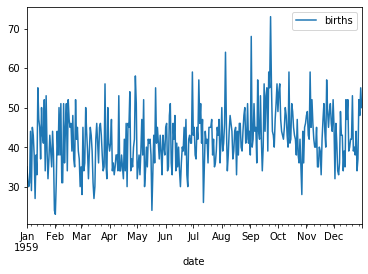

In [8]:
f_birth.plot()

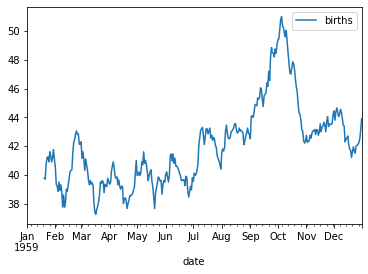

In [9]:
f_birth_mean = f_birth.rolling(window = 20).mean() # easier to observe the trend
f_birth_mean.plot()

# Decompose time series into its components

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [11]:
# Multiplicative Decomposition
result_mul = seasonal_decompose(f_birth['births'], model='multiplicative', extrapolate_trend='freq')

In [12]:
# Additive Decomposition
result_add = seasonal_decompose(f_birth['births'], model='additive', extrapolate_trend='freq')

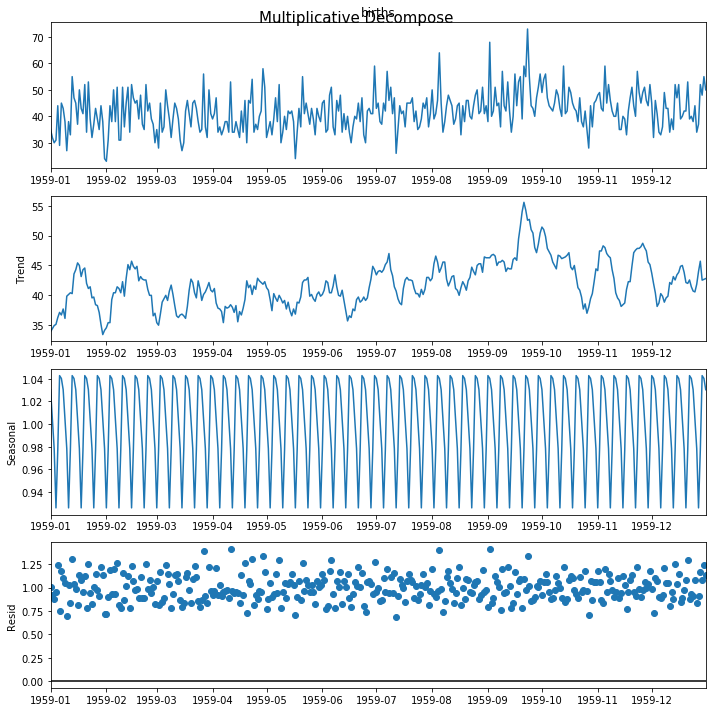

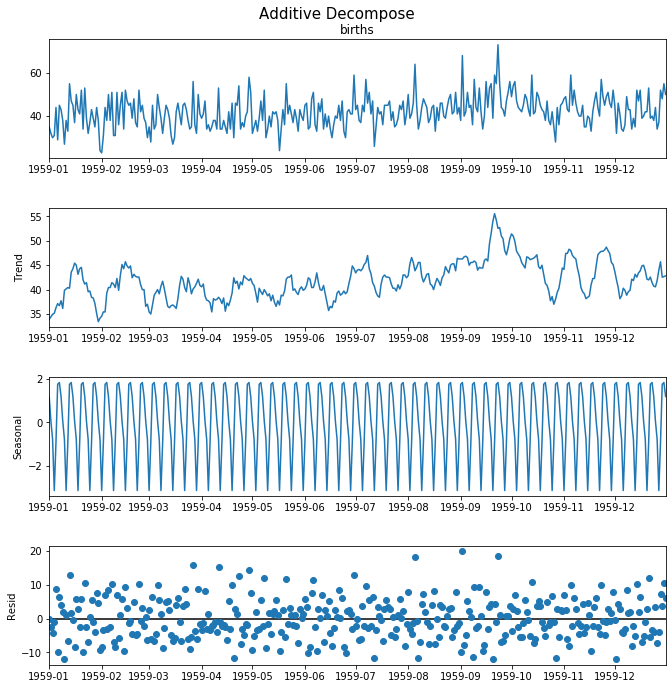

In [13]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15)
result_add.plot().suptitle('Additive Decompose', fontsize=15)
plt.tight_layout(pad=3.08)
plt.show()


Residuals of the additive decomposition has some pattern left over.
The multiplicative decomposition, however, looks quite random which is good.
So ideally, multiplicative decomposition should be preferred for this particular series'


# Simple prediction uing shift function. Baseline model

In [14]:
f_birth_baseline = f_birth.copy()

In [15]:
f_birth_baseline['birth_forecast'] = f_birth_baseline['births'].shift(1)

In [16]:
f_birth_baseline.head()

,births,birth_forecast
date,,
1959-01-01,35,NaN
1959-01-02,32,35.0
1959-01-03,30,32.0
1959-01-04,31,30.0
1959-01-05,44,31.0


In [17]:
# Calculate mean squared error of this simple baseline model

In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [19]:
f_birth_baseline.dropna(inplace=True) # drop nan value

In [20]:
f_birth_baseline_error = np.sqrt(mean_squared_error(f_birth_baseline['births'], f_birth_baseline['birth_forecast'])) # take square root of mse
f_birth_baseline_error

9.177283229394606

# ARIMA Autoregressive(p) Integrated(d) Moving average(q)

#### Finding p,d,q values for a simple model

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [22]:
f_birth.head()

,births
date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


In [23]:
result = adfuller(f_birth_series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.808291
p-value: 0.000052


In [24]:
# as p value is less than 0.05 we can say the data is stationary

#### plot_acf to calculate thevalue of p

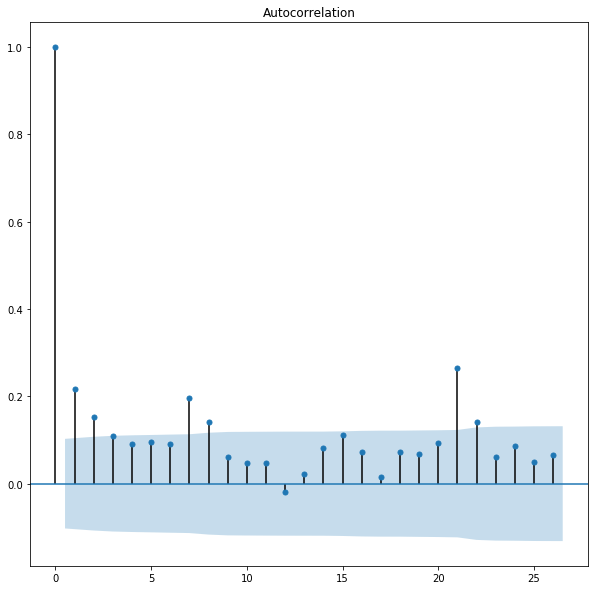

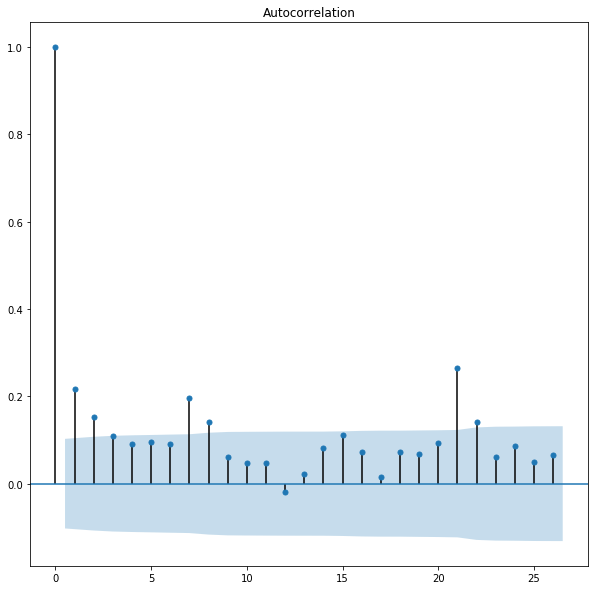

In [25]:
plot_acf(f_birth_series)

In [26]:
# p value could be 2,3

#### plot_pacf is to calculate value of q

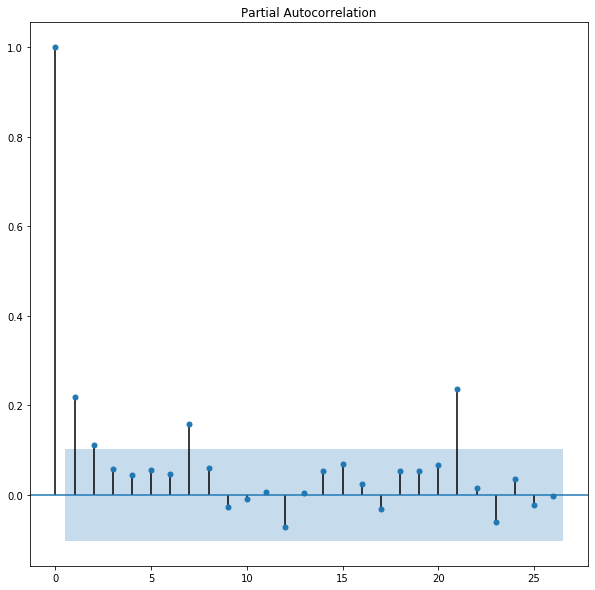

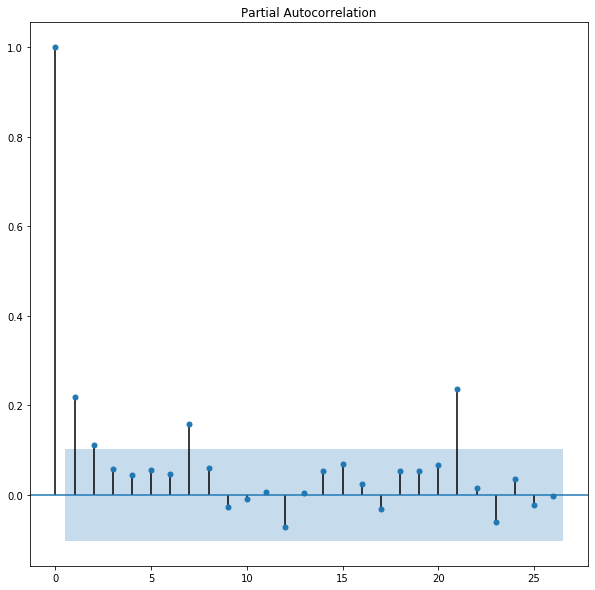

In [27]:
plot_pacf(f_birth_series)

In [28]:
# q  value could be 2,3

# Simple Modelling

In [29]:
from statsmodels.tsa.arima_model import ARIMA
import warnings

In [30]:
# Split the dataset
split = int(len(f_birth_series) * 0.9)
f_birth_series_train = f_birth_series[:split]
f_birth_series_test = f_birth_series[split:]

In [31]:
model = ARIMA(f_birth_series_train, order=(3,0,3))
model_fit = model.fit()
print('AIC Score', model_fit.aic)
model_forecast = model_fit.forecast(steps=37)[0]
# model_forecast
print('RMSE -', np.sqrt(mean_squared_error(f_birth_series_test, model_forecast)))

# Modelling using a function to hyper tune the ARIMA parameters, split data

In [35]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = np.sqrt(mean_squared_error(test, predictions))
    return error




# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [41]:
p_values = [2]
d_values = [1] # range(0, 2)
q_values = [1] # range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(f_birth_series, p_values, d_values, q_values)

ARIMA(2, 1, 1) RMSE=7.417
Best ARIMA(2, 1, 1) RMSE=7.417
